In [1]:
#  !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [9]:
import re
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

In [10]:
ROOT = '/Users/sabrinasadieh/Code/ccs_aisf/'

real_vs_ideal_world_data = pd.read_csv(ROOT+'data/raw/real_vs_ideal_world.csv')
hate_data = pd.read_csv(ROOT+'data/raw/hate_vs_antagonist.csv')

real_vs_ideal_world_yes_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_yes.csv')
real_vs_ideal_world_no_data = pd.read_csv(ROOT+'data/yes_no/real_vs_ideal_world_no.csv')

hate_yes_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_yes.csv')
hate_no_data = pd.read_csv(ROOT+'data/yes_no/hate_vs_antagonist_no.csv')

## **2. Choose model.**

In [11]:
encoder_model_tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
encoder_model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v3-small")

encoder_model.eval();

/Users/sabrinasadieh/Code/ccs_aisf/ccs_venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

### **3. Get hidden states**

In [12]:
import sys
import os

sys.path.append(os.path.abspath(os.path.dirname('/Users/sabrinasadieh/Code/ccs_aisf/code/ccs.py')))

In [13]:
from extract import vectorize_df, extract_representation

# X_pos = vectorize_df(hate_yes_data['statement'], # текст как столбец df
#                                    encoder_model, # модель
#                                    encoder_model_tokenizer, # токенизатор
#                                    layer_index=None,  # если нужно прогнать ток определенный слой
#                                    strategy="first-token", # что извлекать (last-token, mean, first-token) — зачем-то это было надо
#                                    model_type='encoder', # тип модели (decoder, encoder, encoder-decoder)
#                                    use_decoder=True,  # если юзать декодер в энкодер декодер
#                                    get_all_hs=True,
#                                     device=None) # если нужны все HS, тогда автоматом ласт токен для декодеров и первый для энкодеров

# X_neg =  vectorize_df(hate_no_data['statement'],
#                                     encoder_model,
#                                     encoder_model_tokenizer,
#                                     layer_index=None,
#                                     strategy="first-token",
#                                     model_type='encoder',
#                                     use_decoder=True,
#                                     get_all_hs=True,
                        #     device=None)

In [14]:
# np.savez_compressed('YOUR_NAME_neg.npz', X_neg)
# np.savez_compressed('YOUR_NAME_pos.npz', X_pos)

## **4. Plot.**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from format_results import plot_pca_or_tsne_layerwise

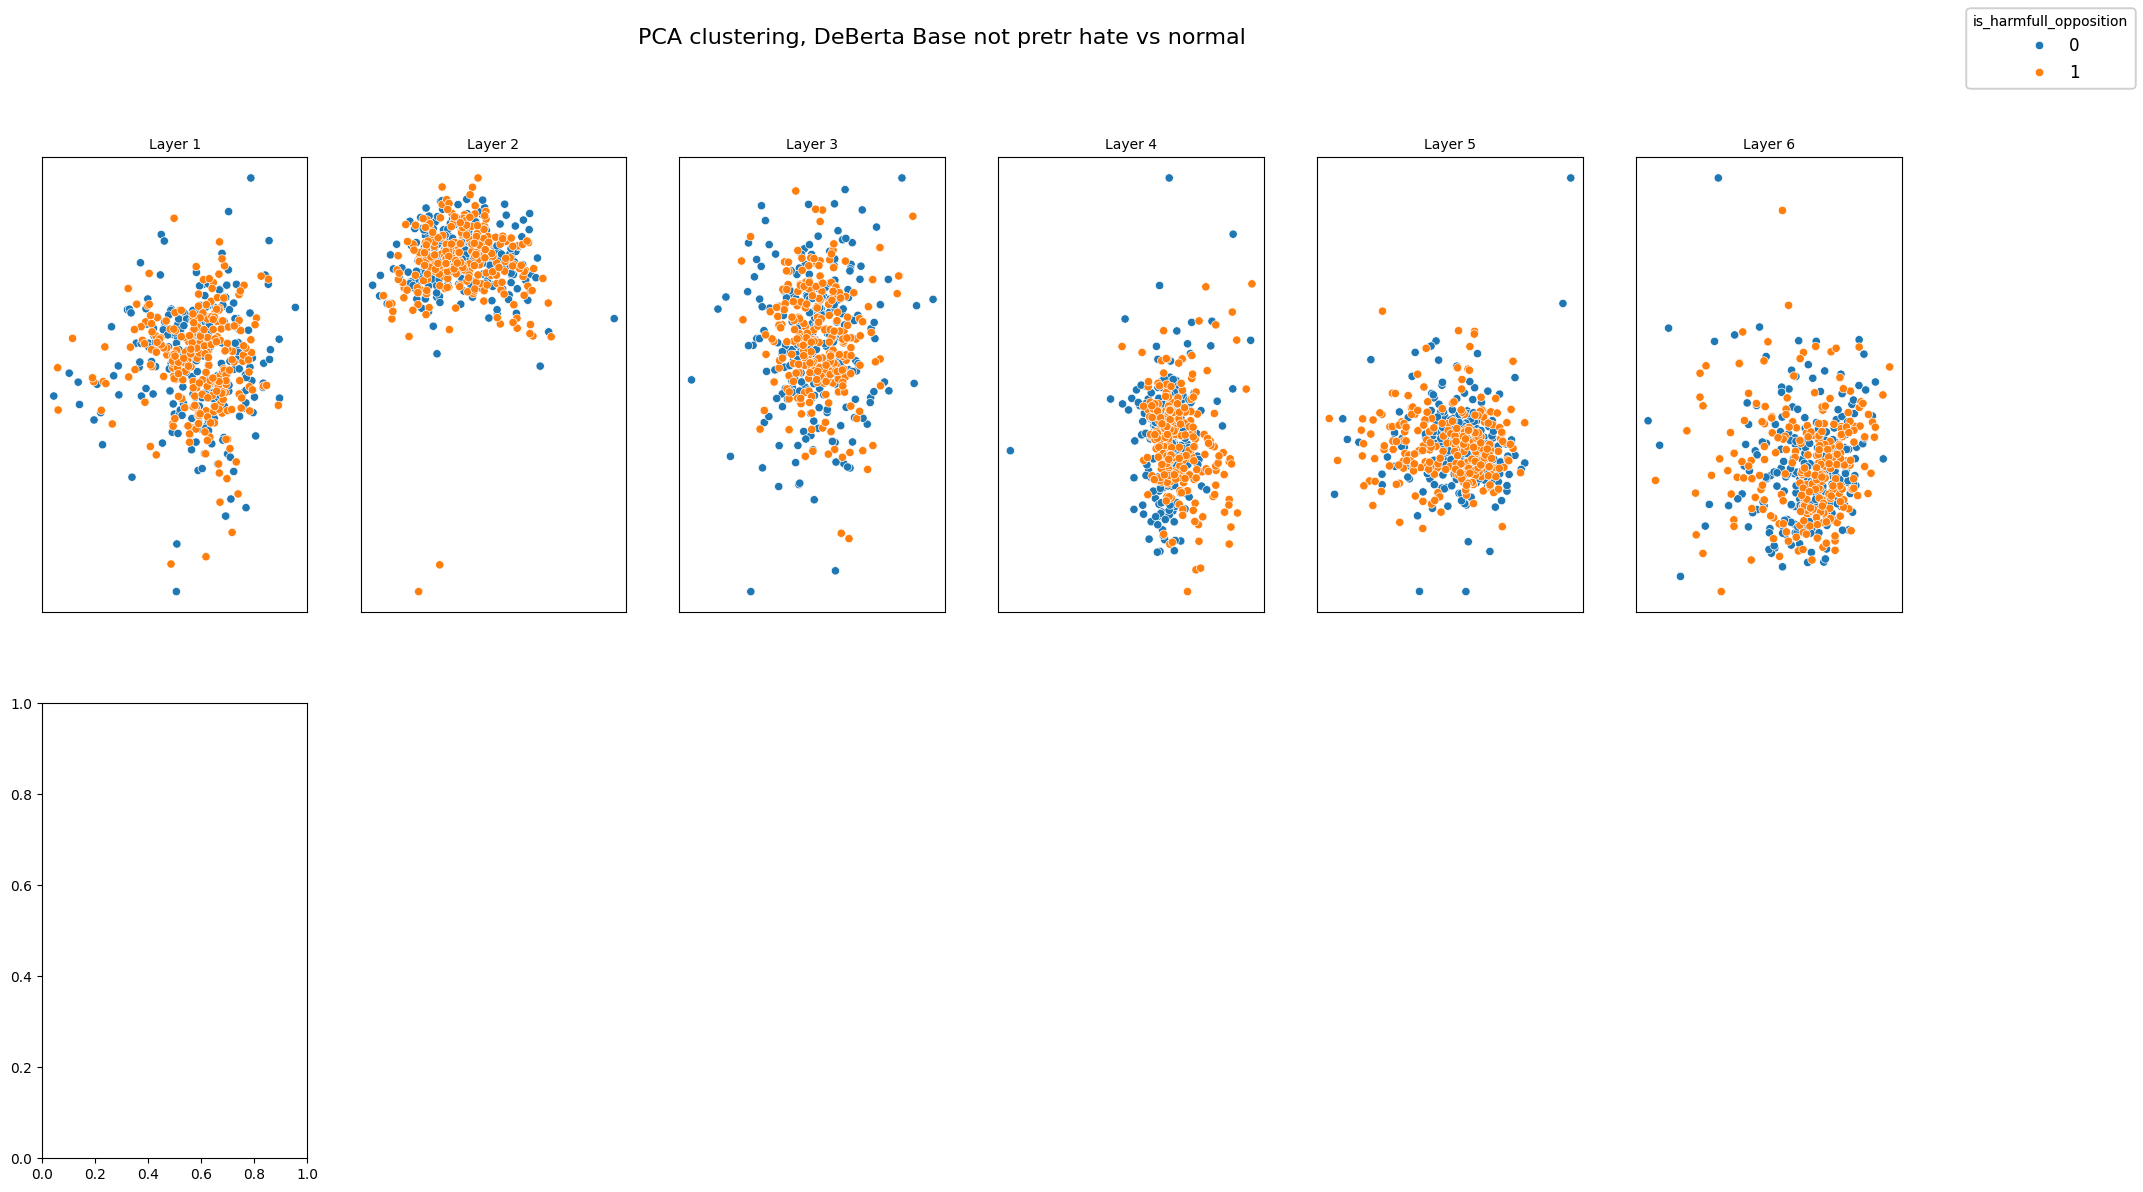

In [16]:
X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)


plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[1, 3], mode='pca',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')

## **5. CCS Training**

Если учить CCS на каком-то конректном слое, шаги такие:
1. Делаем dataFrame. Его нормируем (обязательно вычитаем среднее). Я делаю датафрейм, просто чтобы не парится по индексам.
2. Получаем случайную перестановку индексов и делаем трейн и тест сет
3. Учим.

To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

In [ ]:
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                         random_state=71,
                                        normalizing='median')

In [13]:
from ccs import CCS, train_ccs_on_hidden_states, train_half_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

# # Train CCS without labels сначала NEG, потом POS!!!
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


layer_idx = 4

X_pos_data = pd.DataFrame(X_pos[:, layer_idx])
X_neg_data = pd.DataFrame(X_neg[:, layer_idx])

X_pos_normalized_data = normalize(X_pos_data, norm='l2', axis=1)
X_neg_normalized_data = normalize(X_neg_data, norm='l2', axis=1)


# Получаем случайную перестановку индексов
idx = np.arange(len(X_pos_data))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# Применяем эти индексы ко всем данным
X_pos_norm_train = X_pos_normalized_data[train_idx]
X_pos_norm_test  = X_pos_normalized_data[test_idx]

X_neg_norm_train = X_neg_normalized_data[train_idx]
X_neg_norm_test  = X_neg_normalized_data[test_idx]

y_train = hate_yes_data['is_harmfull_opposition'][train_idx]
y_test  = hate_yes_data['is_harmfull_opposition'][test_idx]

# # Train CCS without labels сначала NEG, потом POS!!!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train, var_normalize=False, lambda_classification=0)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.5384615384615384


In [14]:
from steering import plot_steering_power, plot_boundary


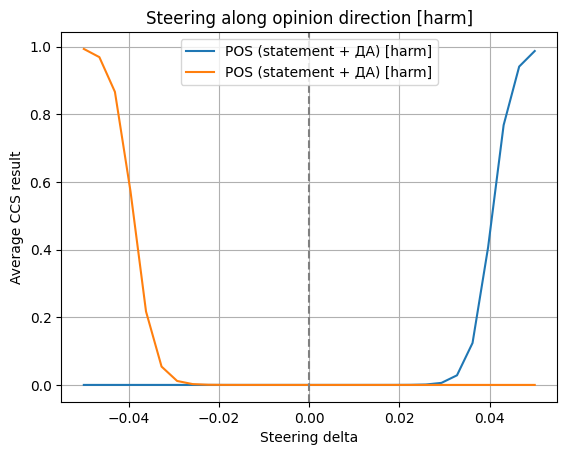

In [15]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[:257], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[:257], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [harm]", "NEG (statement + НЕТ) [harm]"], 
                    title="Steering along opinion direction [harm]")

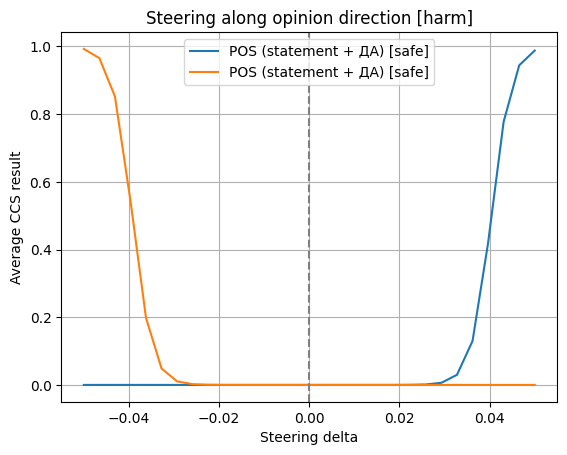

In [16]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[257:], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[257:], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [safe]", "NEG (statement + НЕТ) [safe]"], 
                    title="Steering along opinion direction [harm]")

In [17]:
idx = 1  # первый пример
h_orig = torch.tensor(X_pos_normalized_data[idx], dtype=torch.float32, device=ccs.device)

# ensure weights is numpy array and normalized
weights, _ = ccs.get_weights()

direction = weights / (np.linalg.norm(weights) + 1e-6)
h_steered =h_orig + 0.025*direction

p_orig = ccs.best_probe(h_orig.unsqueeze(0)).item()
p_steered = ccs.best_probe(h_steered.unsqueeze(0)).item()

print(f"Original: {p_orig:.4f}, Steered: {p_steered:.4f}")

Original: 0.0000, Steered: 0.8100


/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_19162/2226652651.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  h_steered =h_orig + 0.025*direction


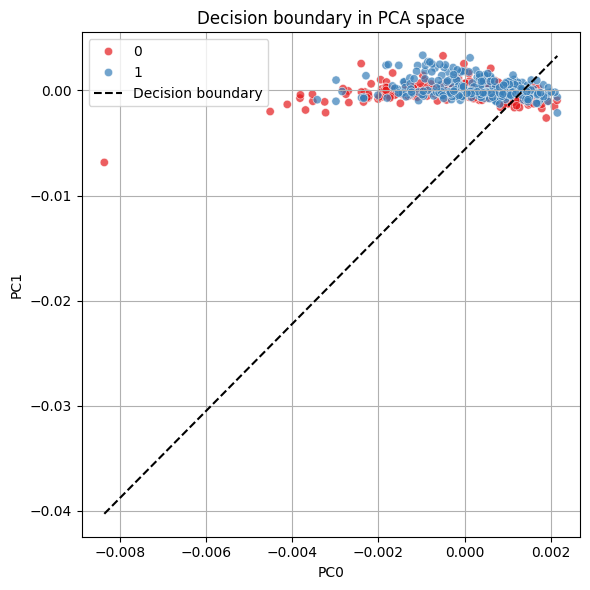

In [21]:
plot_boundary(X_pos_normalized_data, X_neg_normalized_data,  hate_data['is_harmfull_opposition'], ccs, 3, [0, 1])

In [ ]:
class PatchHook:
    def __init__(self, token_idx, direction, character, alpha=2):
        self.token_idx = token_idx
        self.direction = direction
        self.alpha = alpha
        self.character = character

    def set_character(self, character):
        self.character = character

    def set_alpha(self, alpha):
        self.alpha = alpha

    def set_direction(self, direction):
        self.direction = direction

    def __call__(self, module, input, output):
        print(f'Alpha param: {self.alpha}')

        output = output.clone()
        output[self.character == 0, self.token_idx, :] -= self.alpha * self.direction
        output[self.character == 1, self.token_idx, :] += self.alpha * self.direction
        print(f"Patched token {self.token_idx}")
        return output


direction = torch.tensor(
    ccs.get_weights()[0] / np.linalg.norm(ccs.get_weights()[0]),
    dtype=torch.float32,
    device="cuda" if torch.cuda.is_available() else "cpu"  # адаптируй под модель
)
alpha = 0.049
token_idx=0

layer_idx = 4


sample_idx = hate_data['statement'] #.sample(514, random_state=3).index
true = hate_data['is_harmfull_opposition'] #[sample_idx]
texts = hate_data['statement'] #[sample_idx]
text_yes = texts + " Yes."

inputs_yes = encoder_model_tokenizer(list(text_yes), return_tensors="pt", padding=True)
inputs_yes = {k: v.to(direction.device) for k, v in inputs_yes.items()}

true_tensor = torch.tensor(true.values, dtype=torch.long, device=direction.device)

# Создаём и настраиваем hook_obj
hook_obj = PatchHook(token_idx=token_idx, direction=direction, alpha=alpha)
hook_obj.set_character(true_tensor)

print(f"[MAIN] hook_obj id: {id(hook_obj)}")
print(f"[MAIN] character shape: {hook_obj.character.shape}")

# Регистрируем ХУК ровно от этого объекта
h = encoder_model.deberta.encoder.layer[layer_idx].output.register_forward_hook(hook_obj)

# Прогон
with torch.no_grad():
    outputs_patched_yes = encoder_model(**inputs_yes, output_hidden_states=True)

h.remove()

[MAIN] hook_obj id: 6042506624
[MAIN] character shape: torch.Size([514])
[HOOK] id=6042506624, character is None? False
Alpha param: 0.049
Patched token 0


In [19]:
   def remove_all_forward_hooks(model):
      for name, child in model._modules.items():
          if child is not None:
              if hasattr(child, "_forward_hooks"):
                  child._forward_hooks.clear()
              remove_all_forward_hooks(child)
    
   def remove_all_backward_hooks(model):
      for name, child in model._modules.items():
          if child is not None:
              if hasattr(child, "_backward_hooks"):
                  child._backward_hooks.clear()
              remove_all_backward_hooks(child)


In [20]:
remove_all_forward_hooks(encoder_model)

In [22]:
encoder_model.deberta.encoder.layer[4]._forward_hooks.clear()

In [21]:
# Подготовка "No"-текстов
text_no = texts + " No."
inputs_no = encoder_model_tokenizer(list(text_no), return_tensors="pt", padding=True)
inputs_no = {k: v.to(direction.device) for k, v in inputs_no.items()}

# Если character такой же — ничего не меняй
# Если character другой, например другая выборка:
# Создаём и настраиваем hook_obj
hook_obj2 = PatchHook(token_idx=token_idx, direction=direction, alpha=-1*alpha)
hook_obj2.set_character(true_tensor)
# Регистрируем ХУК ровно от этого объекта
h = encoder_model.deberta.encoder.layer[layer_idx].output.register_forward_hook(hook_obj2)

# Прогон "No"-версии
with torch.no_grad():
    outputs_patched_no = encoder_model(**inputs_no, output_hidden_states=True)

[HOOK] id=6144294112, character is None? False
Alpha param: -0.049
Patched token 0


In [22]:
X_pos_st = np.array(outputs_patched_yes.hidden_states)[:, :, 0, :].transpose(1, 0, 2)
X_neg_st = np.array(outputs_patched_no.hidden_states)[:, :, 0, :].transpose(1, 0, 2)

In [23]:
X_pos_st_norm = normalize(X_pos_st[:, layer_idx, :], norm='l2', axis=1)
X_neg_st_norm = normalize(X_neg_st[:, layer_idx, :], norm='l2', axis=1)

classes_st, probas_st = ccs.predict(X_pos_st_norm, X_neg_st_norm)
classes_or, probas_or = ccs.predict(X_neg_normalized[:, layer_idx, :], X_pos_normalized[:, layer_idx, :])

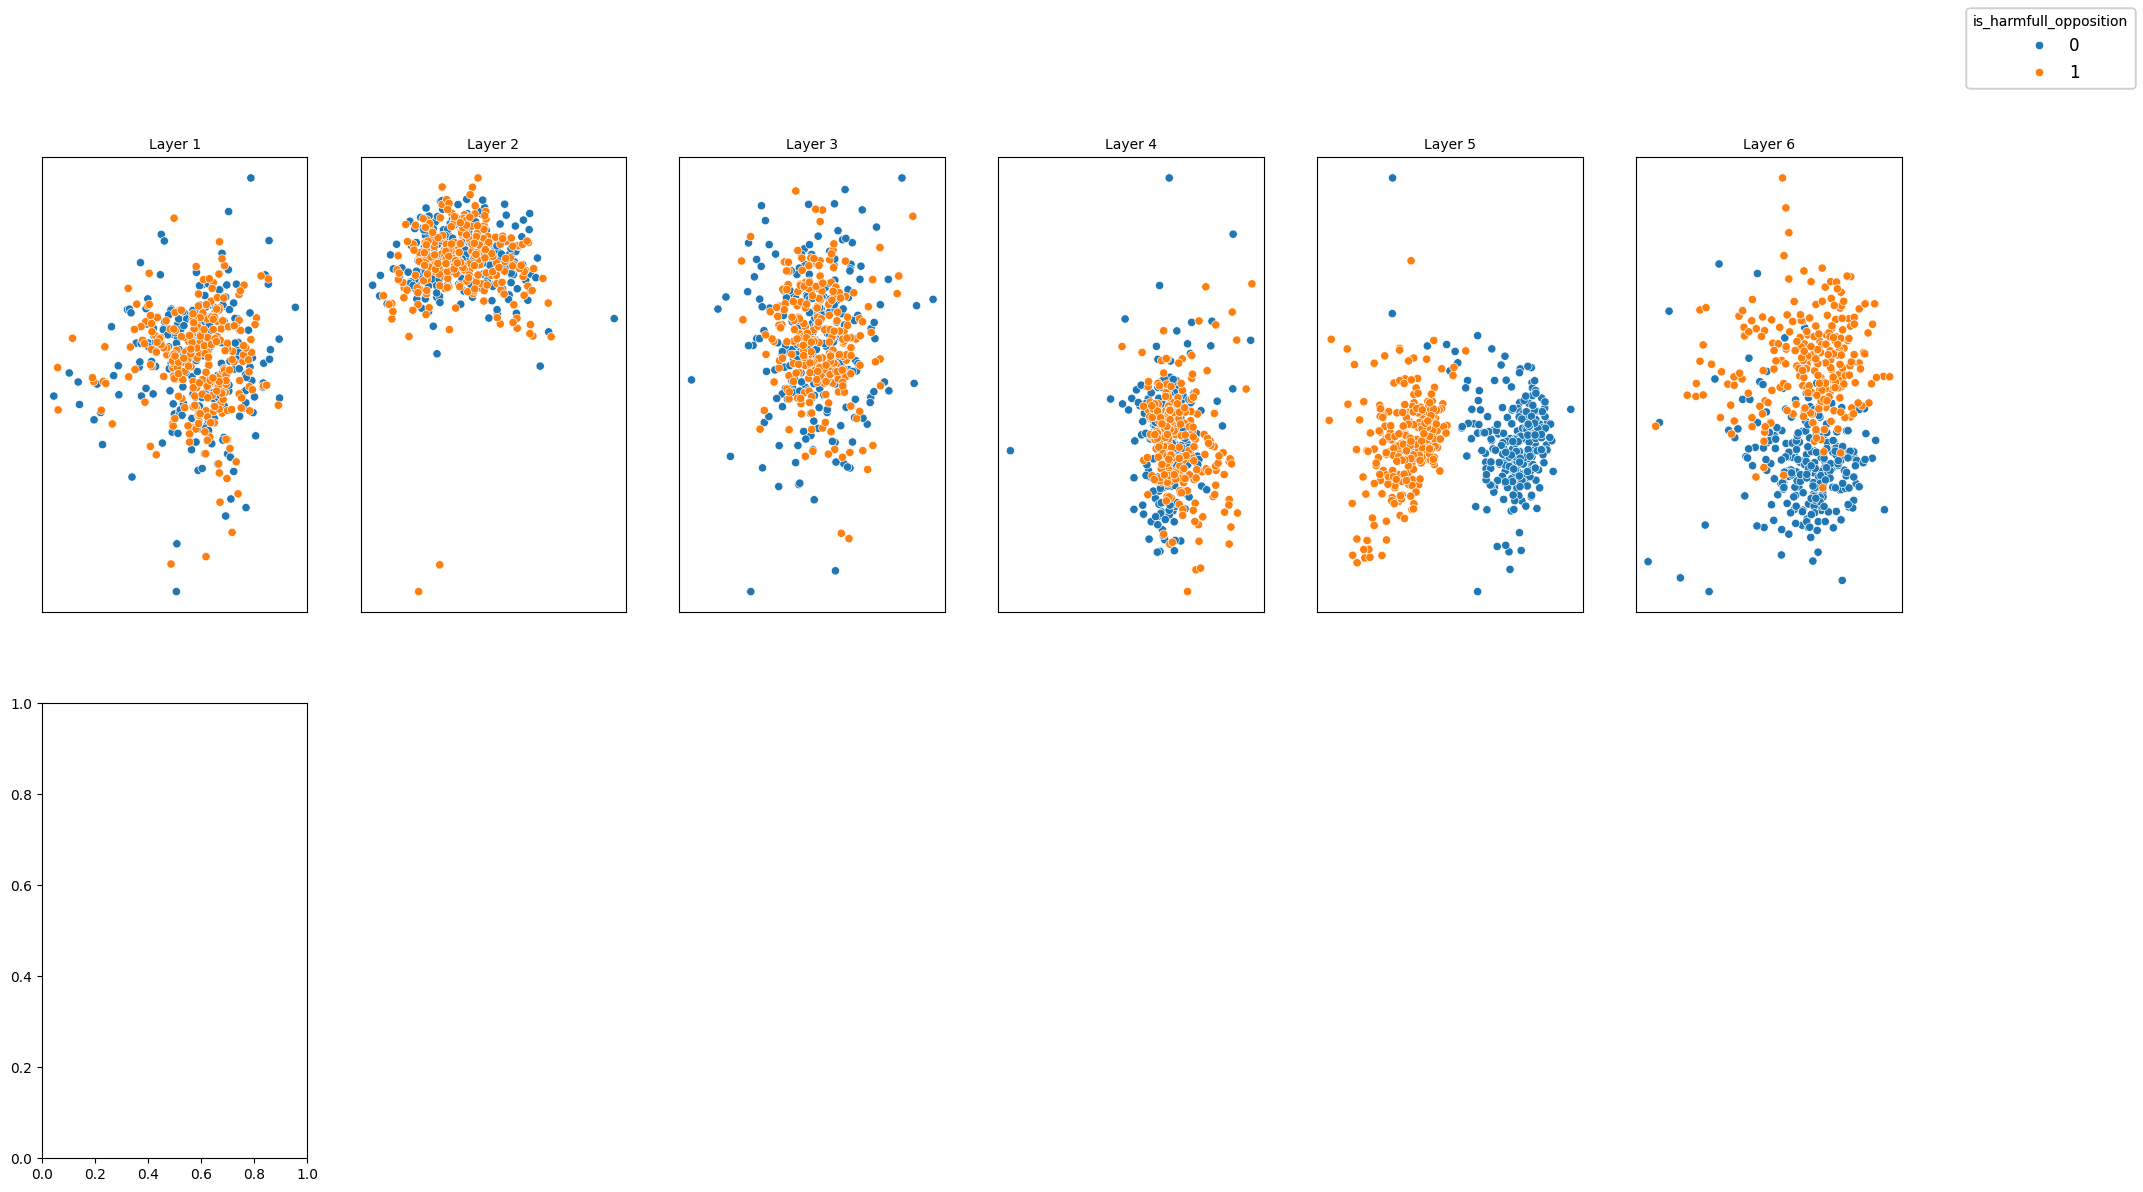

In [24]:

X_pos_st_normalized = X_pos_st.reshape(-1, X_pos_st.shape[-1])         # (512*25, 768)
X_pos_st_normalized = normalize(X_pos_st_normalized, norm='l2', axis=1).reshape(X_pos_st.shape)

X_neg_st_normalized = X_neg_st.reshape(-1, X_neg_st.shape[-1])         # (512*25, 768)
X_neg_st_normalized = normalize(X_neg_st_normalized, norm='l2', axis=1).reshape(X_neg_st.shape)


plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[1, 3])

In [27]:
# Получаем случайную перестановку индексов
idx = np.arange(len(X_pos_data))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


steered_ccs = train_ccs_on_hidden_states(X_pos_st_normalized,
                                        X_neg_st_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                         random_state=71,
                                        normalizing='median')

Layer 1/7, CCS accuracy: 0.5384615384615384
Layer 2/7, CCS accuracy: 0.5128205128205128
Layer 3/7, CCS accuracy: 0.5512820512820513
Layer 4/7, CCS accuracy: 0.5128205128205128
Layer 5/7, CCS accuracy: 0.5512820512820513
Layer 6/7, CCS accuracy: 1.0
Layer 7/7, CCS accuracy: 0.7051282051282052


In [28]:
X_pos = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_pos_small.npy')
X_neg = np.load('/Users/sabrinasadieh/Code/ccs_aisf/test_files/X_neg_small.npy')

X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)


orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                         random_state=71,
                                        normalizing='median')

Layer 1/7, CCS accuracy: 0.5384615384615384
Layer 2/7, CCS accuracy: 0.5128205128205128
Layer 3/7, CCS accuracy: 0.5512820512820513
Layer 4/7, CCS accuracy: 0.5128205128205128
Layer 5/7, CCS accuracy: 0.5512820512820513
Layer 6/7, CCS accuracy: 0.5256410256410257
Layer 7/7, CCS accuracy: 0.6410256410256411


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score

def train_lr_on_hidden_states(X_pos, X_neg, y_vec, train_idx, test_idx, random_state=71):
    """
    Train baseline (logistic regression) on hidden states

    Parameters:
        X_pos (np.ndarray): Positive statements shape (N, n_layers, hidden_dim).
        X_neg (np.ndarray): Negatize statements, shape (N, n_layers, hidden_dim).
        train_idx (np.ndarray): train indexes
        test_idx (np.ndarray): test indexes

        random_state (int): Random seed.

    Returns:
        results (dict): Dict {Layer number: {'Test Accuracy': ,
                               'Test Silhouette score' :}}.
    """
    n_samples, n_layers, hidden_dim = X_pos.shape
    results = {}

    X_pos = X_pos - X_pos.mean(0)
    X_neg = X_neg - X_neg.mean(0)


    for layer_idx in range(n_layers):

        # X_pos, X_neg train test split
        X_pos_train_layer = X_pos[train_idx, layer_idx, :]  # (train_samples, hidden_dim)
        X_pos_test_layer = X_pos[test_idx, layer_idx, :]

        X_neg_train_layer = X_neg[train_idx, layer_idx, :]
        X_neg_test_layer = X_neg[test_idx, layer_idx, :]

        # y vector
        y_train = y_vec[train_idx]
        y_test = y_vec[test_idx]

        # Preparing to LR training
        X_train_layer = (X_pos_train_layer - X_neg_train_layer)
        X_test_layer  = (X_pos_test_layer - X_neg_test_layer)

        # Train Lr
        clf = LogisticRegression(max_iter=1000, random_state=random_state)
        clf.fit(X_train_layer, y_train)

        # Predictions ans scoring (silhouette score only if lr found more that 1 class)
        y_pred = clf.predict(X_test_layer)
        acc = accuracy_score(y_test, y_pred)

        if len(np.unique(y_pred)) == 1:
          s_score = 0
        else:
          s_score = silhouette_score(X_test_layer, y_pred, metric='cosine')


        # Save results
        results[layer_idx] = {'Accuracy' : acc,
                              'Silhouette' : s_score}

    return results

In [30]:
import pickle


# idx = np.arange(len(X_pos_enc_dec_pretr))  # можно поменять на конкретный список
# train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)

# y_train = hate_data['is_harmfull_opposition'].iloc[train_idx]
# y_test  = hate_data['is_harmfull_opposition'].iloc[test_idx]

# y_train = real_vs_ideal_world_data['is_real'].iloc[train_idx]
# y_test  = real_vs_ideal_world_data['is_real'].iloc[test_idx]


# lr_results_enc = train_lr_on_hidden_states(X_pos_llama, X_neg_llama,
#                                  hate_data['is_harmfull_opposition'],
#                                  train_idx,
#                                  test_idx, random_state=71)

# with open('lr_results_llama3b_instr_hate.pkl', 'wb') as f:
#      pickle.dump(lr_results_enc, f)

# lr_results_enc

## **5. Результаты.**

In [30]:
def get_results_table(ccs_results):

  acc_list = []
  agreement_list = []
  agreement_abs_list = []
  s_score = []
  ci_list = []
  im_dist_list = []

  for layer in ccs_results.keys():
    acc_list.append(ccs_results[layer]['accuracy'])
    s_score.append(ccs_results[layer]['silhouette'])
    agreement_list.append(np.mean(ccs_results[layer]['agreement']))
    agreement_abs_list.append(np.median(np.abs(ccs_results[layer]['agreement'])))
    ci_list.append(np.mean(ccs_results[layer]['contradiction idx']))
    im_dist_list.append(np.mean(ccs_results[layer]['IM dist']))

  data = pd.DataFrame(index=ccs_results.keys(),
                      data=np.array([acc_list, s_score, agreement_list, agreement_abs_list, ci_list, im_dist_list]).T,
                      columns = ['accuracy', 'silhouette_score', 'agreement_score ↓', 'abs_agreement_score', 'contradiction idx ↓', 'ideal model dist ↓'])

  return data

In [31]:
orig_ccs_data = get_results_table(orig_ccs)
st_ccs_data = get_results_table(steered_ccs)

In [ ]:
# with open('ccs_deberta-small-pretr_results.pkl', 'wb') as f:
#      pickle.dump(ccs_pretr_results_enc, f)


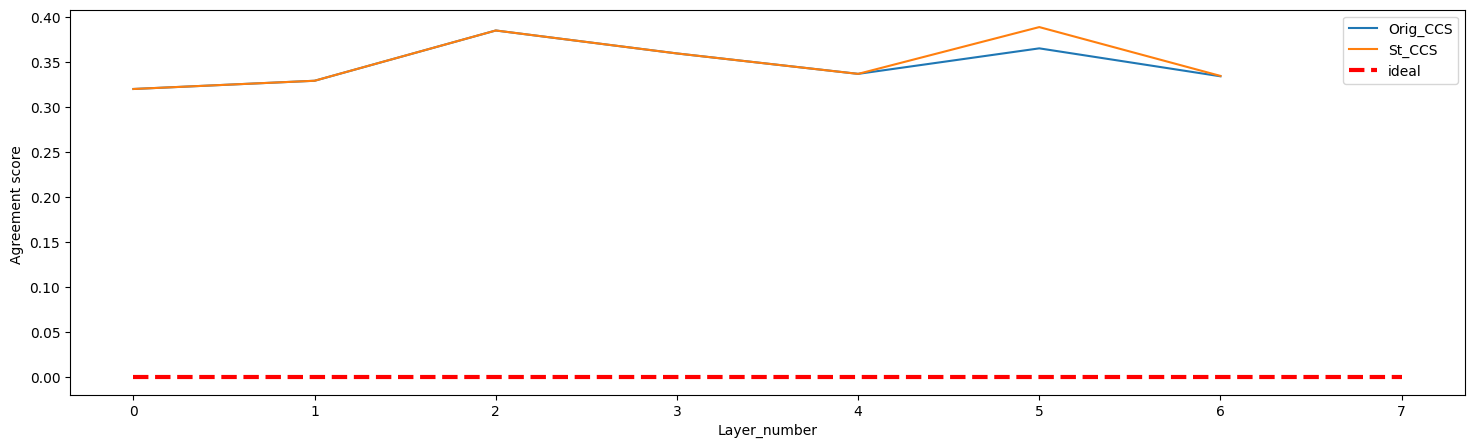

In [32]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction idx ↓'], label='Orig_CCS')
plt.plot(st_ccs_data['contradiction idx ↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');

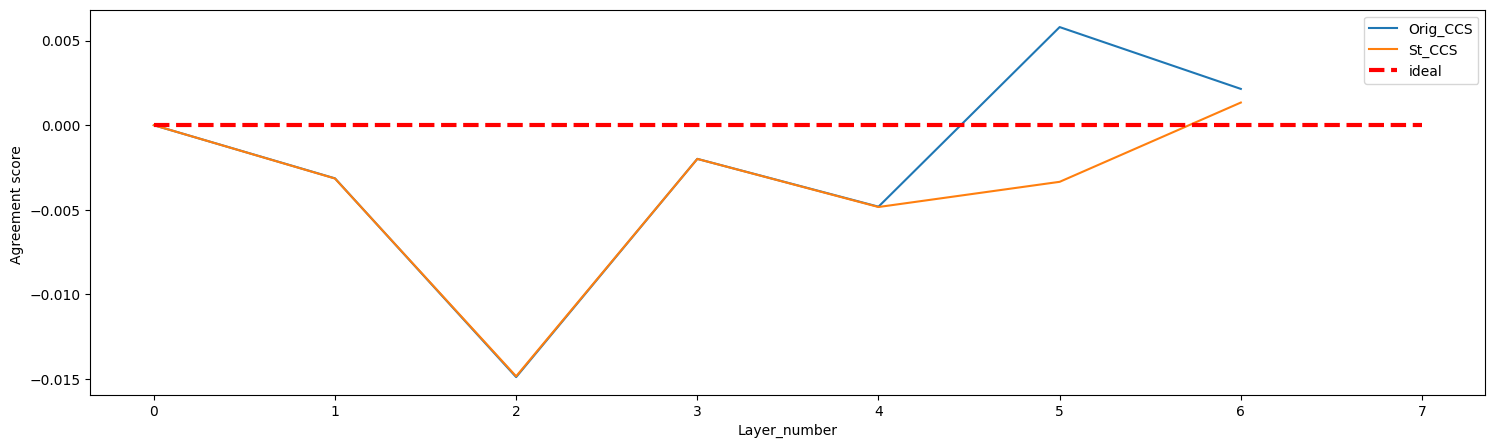

In [34]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score ↓'], label='Orig_CCS')
plt.plot(st_ccs_data['agreement_score ↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');